In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import mne
import warnings
import random

from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

tf.keras.utils.set_random_seed(123)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [2]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [3]:
N_S = 2
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

X2,Y2 = Extract_data_from_subject(root_dir,N_S,datatype)

In [4]:
Subj_2 = Select_time_window(X = X2, t_start = Tstart, t_end = Tend, fs = fs)

In [5]:
Subj_2_inner, Labels_2_inner = Transform_for_classificator(X = Subj_2, Y = Y2, Classes = [['ALL']], Conditions = [['Inner']])

Now that we have our data imported, windows sliced and classes and conditions picked, we need to do some final adjustments such as one-hot encoding.

In [6]:
Labels_2_inner[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = Labels_2_inner[:,1]
labels_ = pd.get_dummies(labels)

In [7]:
X = Subj_2_inner
y = labels_

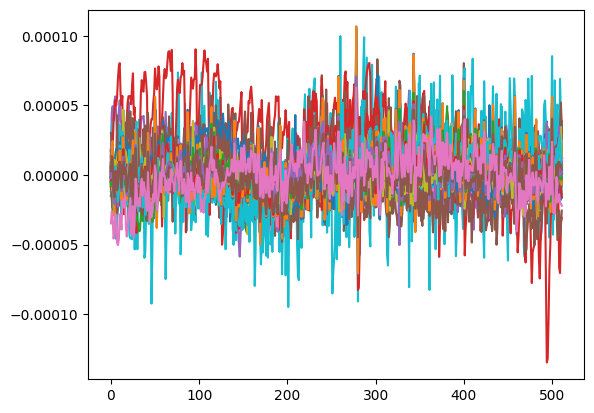

In [8]:
for i in range(X.shape[1]-1):
    plt.plot(X[1,i,:]);

Looking at the data, we can see that the magnitude of the signal is very small. This may cause problems if our biases and weights are too large relative to our input data. For expediency, we will multiply the data values by a constant rather than create a normalization pipeline.

In [9]:
means = np.mean(X, axis=(1,2))
std_ = np.std(X, axis=(1,2))
x_norm = np.zeros(shape = X.shape)
for i in range(X.shape[0]):
    Xmsub = (X[i,:,:] - means[i])/std_[i]
    
    x_norm[i] = Xmsub

In [10]:
means.shape

(240,)

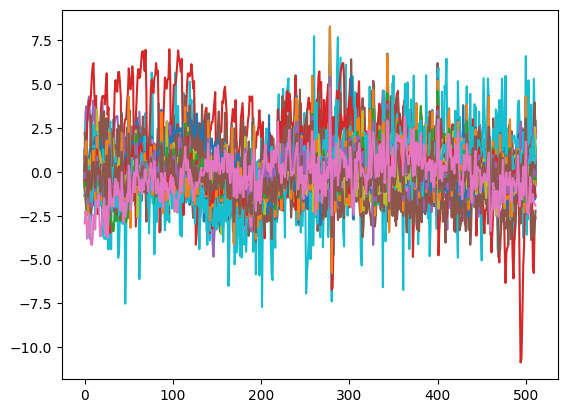

In [11]:
for i in range(x_norm.shape[1]-1):
    plt.plot(x_norm[1,i,:]);

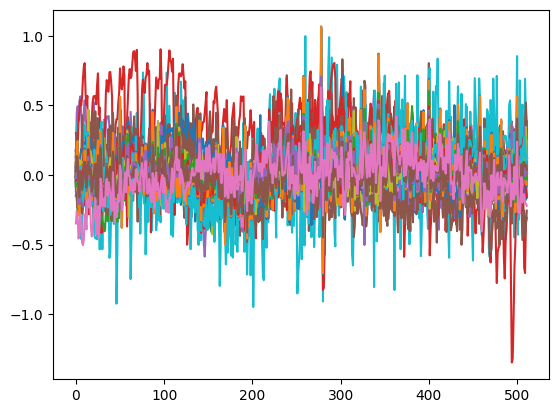

In [12]:
X_resize = X * (10**4)
for i in range(X_resize.shape[1]-1):
    plt.plot(X_resize[1,i,:]);

In [13]:
# split data into train and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X_resize, y, test_size=0.1)

In [14]:
# split off our validation data set
X_train1, X_val, y_train1, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1)

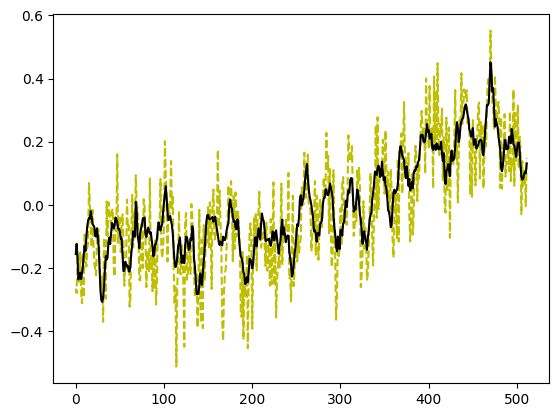

In [15]:
data_shape = X_train1.shape
noise = np.random.normal(loc=0.0, scale=0.1, size=data_shape)
X_noisy = np.add(X_train1, noise)
plt.plot(X_noisy[1,64,:],'y--');
plt.plot(X_train1[1,64,:], 'k');

In [16]:
X_train = np.concatenate((X_train1,X_noisy))
print(X_train.shape)

y_train = np.concatenate((y_train1,y_train1))
y_train.shape

(388, 128, 512)


(388, 4)

In [17]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
print(input_shape)

(128, 512, 1)


In [18]:
print(X_train.shape)
print(X_test.shape)

(388, 128, 512)
(24, 128, 512)


## Deciding on a kernel size

Lets consider how much information our Conv2D layers can see, from a frequency perspective:

> - 1x7: 7 samples / 256 Hz = 0.0273 sec. window, equivalent to period of 36.6 Hz signal
> - 1x13: 13 / 256 = 0.0508 sec. window, equivalent to period of 19.7 Hz signal
> - 1x21: 21 / 256 = 0.0820 sec. window, equivalent to period of 12.2 Hz signal
> - 1x31: 31 / 256 = 0.1211 sec. window, equivalent to period of 8.3 Hz signal

it is clear that there is a logarithmic relationship between the length of the sample and the equivalent signal period that it represents. Therefore, 31 is the largest kernel we will use, roughly equivalent to the upper range of the theta brainwaves, and half the period of a delta brainwave.

In [22]:
Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
# L1_ = tf.keras.regularizers.L1(l1=0.0005)

def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(32, kernel_size = (1,31), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
#     model.add(layers.Conv2D(8, kernel_size = (128,1), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))    
    # depthwise layer
    model.add(layers.DepthwiseConv2D((128,1), padding = 'valid', activation='relu'))
    # adds max pooling layer
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(200, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Add a second fully connected layer 
    model.add(layers.Dense(50, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5))
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = Adam_, # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

cnn = create_cnn(input_shape)

cnn.summary()       

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 482, 32)      1024      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 241, 32)      0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 1, 241, 32)        4128      
 iseConv2D)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 7712)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               1542600   
                                                                 
 dropout_2 (Dropout)         (None, 200)              

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [23]:
# Train model
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0.000001, patience = 2, start_from_epoch = 3, verbose=1)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor = 0.1,patience = 1, verbose = 1, min_delta = 0.0001, min_lr = 0.0001)

history = cnn.fit(
    X_train,
    y_train,
    epochs=50, 
    batch_size=32, # default
    shuffle = True,
    callbacks=[EarlyStop,ReduceLR], #stops training early if needed
    verbose= 1, # display progress bar with the training loss and metrics
    validation_data = (X_val, y_val),
    validation_freq = 1
)


Epoch 1/50
13/13 [==============================] - 21s 2s/step - loss: 1.3852 - accuracy: 0.2345 - val_loss: 1.3978 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 20s 1s/step - loss: 1.3841 - accuracy: 0.2706 - val_loss: 1.3794 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 20s 2s/step - loss: 1.3795 - accuracy: 0.2887 - val_loss: 1.3758 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 20s 2s/step - loss: 1.3689 - accuracy: 0.3299 - val_loss: 1.3999 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 20s 2s/step - loss: 1.3545 - accuracy: 0.3351 - val_loss: 1.3886 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 20s 2s/step - loss: 1.3130 - accuracy: 0.3995 - val_loss: 1.4218 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 20s 1s/step - loss: 1.2107 - a

In [ ]:
'''#predict model
y_pred = cnn.predict(
    X_test,
    verbose = 1
)'''

In [ ]:
'''print(y_pred)'''

In [24]:
# evaluate model
score = cnn.evaluate(
    X_test,
    y_test,
    batch_size = 24,
    verbose =2
)

1/1 - 0s - loss: 1.7472 - accuracy: 0.2083 - 246ms/epoch - 246ms/step


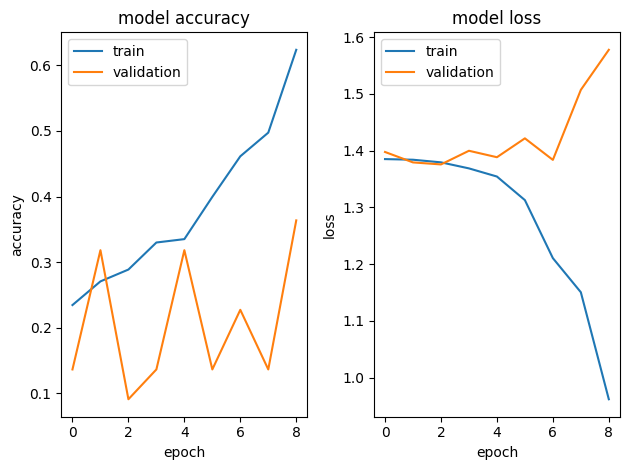

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train','validation'], loc='upper left')

# "Loss"
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train','validation'], loc='upper left')
plt.tight_layout()
